# Assignment 2: Hybrid Images and Scale-space blob detection

In [1]:
# Libraries you will find useful
import numpy as np
import scipy 
import skimage
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from PIL import Image
from skimage import color, io, transform
import time

## Part 1: Hybrid Images

In [2]:
# Crop and align the images such that the objects and their edges are aligned. 
# You are free to use any image editing tool for this and there is no need for code for this step.

# Load cropped and aligned images

In [3]:
# Read aligned input images and convert them to grayscale
def read_image_bw(IMG_NAME):
    img = color.rgb2gray(io.imread(IMG_NAME)).astype(float)
    return img

def read_image_color(IMG_NAME):
    img = io.imread(IMG_NAME).astype(float)
    return img

In [4]:
# Apply a low-pass filter, i.e., a standard 2D Gaussian filter, on the first (smooth) image. 
def low_pass_filter(img, sigma):
    filtered = gaussian_filter(img, sigma=sigma)
    plt.imshow(filtered, cmap="gray")
    plt.figure()
    return filtered

In [5]:
# Apply a high-pass filter on the second image. 
# The paper suggests using an impulse (identity) filter minus a Gaussian filter for this operation.
def high_pass_filter(img, sigma):
    filtered = img - gaussian_filter(img, sigma=sigma)
    plt.imshow(filtered, cmap="gray")
    plt.figure()
    return filtered

In [6]:
# Use your intuition and trial and error to determine good values of σ for the high-pass and low-pass filters
# One of the σ's should always be higher than the other (which one?), but the optimal values can vary from image to image.


In [7]:
# Add or average the tranformed images to create the hybrid image.
def create_hybrid(img1, img2, sigma1, sigma2):
    h, w = img1.shape
    low_image = low_pass_filter(img1, sigma1)
    high_image = high_pass_filter(img2, sigma2)
    
    hybrid = (low_image + high_image)/2
    resized = transform.resize(hybrid, (int(h / 5), int(w / 5)), anti_aliasing=True)
    
    return hybrid, resized

In [8]:
def create_hybrid_color(img1, img2, sigma1, sigma2):
    hybrid_r, hybrid_r_resized = create_hybrid(img1[:, :, 0], img2[:, :, 0], sigma1, sigma2)
    hybrid_g, hybrid_g_resized = create_hybrid(img1[:, :, 1], img2[:, :, 1], sigma1, sigma2)
    hybrid_b, hybrid_b_resized = create_hybrid(img1[:, :, 2], img2[:, :, 2], sigma1, sigma2)
    
    hybrid = np.dstack((hybrid_r, hybrid_g, hybrid_b))
    hybrid = np.clip(hybrid, 0, 255).astype(np.uint8)
    
    return hybrid

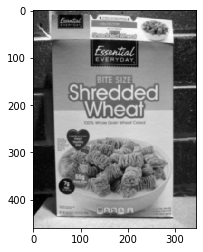

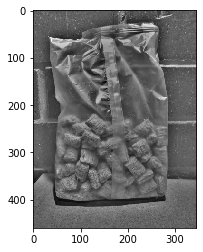

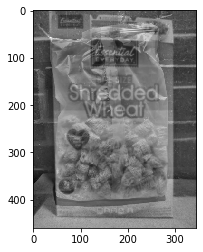

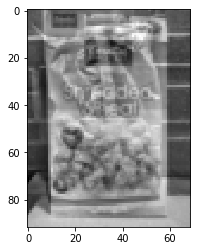

In [9]:
img1bw = read_image_bw("c1.jpg")
img2bw = read_image_bw("c2.jpg")

hybrid_image, resized = create_hybrid(img1bw, img2bw, 1, 15)
plt.imshow(hybrid_image, cmap='gray')
plt.figure()
plt.imshow(resized, cmap="gray")

<Figure size 432x288 with 0 Axes>

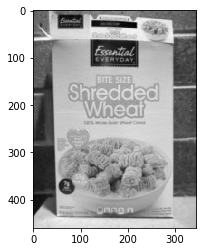

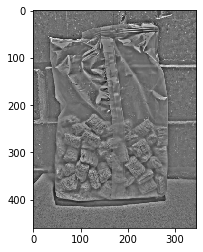

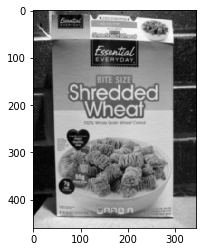

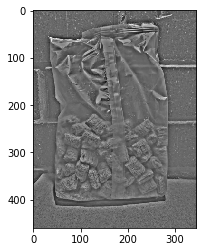

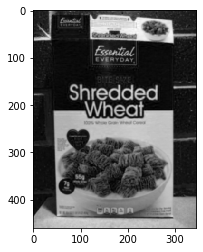

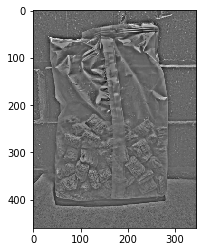

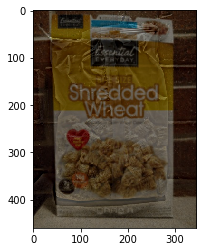

<Figure size 432x288 with 0 Axes>

In [10]:
img1c = read_image_color("c1.jpg")
img2c = read_image_color("c2.jpg")

hybrid_color = create_hybrid_color(img1c, img2c, 1, 5)
plt.imshow(hybrid_color)
plt.figure()

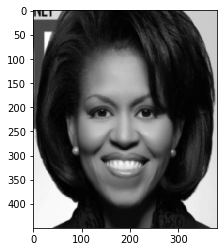

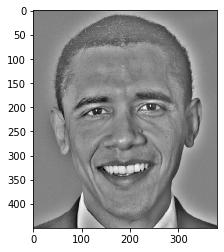

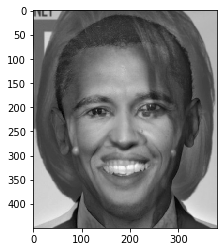

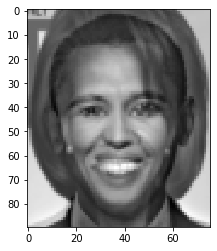

In [11]:
mobama = read_image_bw("mobama_cropped.jpg")
bobama = read_image_bw("bobama_cropped.jpg")

hybrid_image, resized = create_hybrid(mobama, bobama, 1, 15)
plt.imshow(hybrid_image, cmap='gray')
plt.figure()
plt.imshow(resized, cmap="gray")

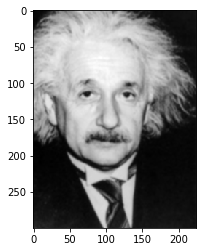

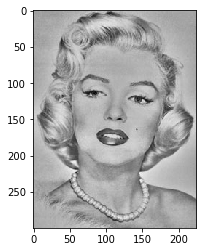

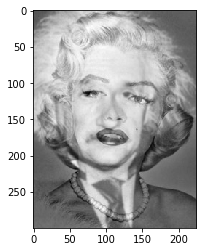

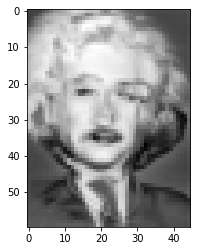

In [12]:
einstein_2 = read_image_bw("einstein_cropped.jpg")
marilyn = read_image_bw("marilyn.jpg")

hybrid_image, resized = create_hybrid(einstein_2, marilyn, 1, 15)
plt.imshow(hybrid_image, cmap='gray')
plt.figure()
plt.imshow(resized, cmap="gray")

## Part 2: Scale-space blob detection

In [13]:
# convert images to grayscale
# rescale the intensities to between 0 and 1 (simply divide them by 255 should do the trick)
def read_img(IMG_NAME):
    dirs = "assignment2_images/"
    img = color.rgb2gray(io.imread(dirs + IMG_NAME)).astype(float)
    return img

In [14]:
# Creating the Laplacian filter
# Pay careful attention to setting the right filter mask size. Hint: Should the filter width be odd or even?
from scipy.ndimage.filters import gaussian_laplace
def laplace_filter(img, sigma):
    filtered = sigma * sigma * gaussian_laplace(img, sigma=sigma)
    return filtered

In [15]:
# filtering the image (two implmementations)
# one that increases filter size, and one that downsamples the image
# For timing, use time.time()
from scipy.ndimage.filters import rank_filter
def detect_blobs_scaling(img, sigma, n, k):
    h, w = img.shape
    scale_space = np.zeros((h, w, n))
    max_scale_space = np.zeros((h, w, n))
    start_time = time.time()
    
    for i in range(n):
        window = sigma * k ** (i)
        filtered = laplace_filter(img, window)
        scale_space[:, :, i] = np.square(filtered)
        max_scale_space[:, :, i] = rank_filter(scale_space[:, :, i], rank = -1, size = (3,3))
    
    compare_scale_space = nonmax_suppress(scale_space, max_scale_space, n, 0.002)
    cx, cy, rad = find_blobs(compare_scale_space, sigma, k)

    print("Time taken:", time.time() - start_time)

    show_all_circles(img, cx, cy, rad)
    
    
def detect_blobs_downsample(img, sigma, n, k):
    h, w = img.shape
    scale_space = np.zeros((h, w, n))
    max_scale_space = np.zeros((h, w, n))
    start_time = time.time()
    
    for i in range(n):
        scaling = 1.0 / (k ** (i))
        downsampled = transform.resize(img, (int(scaling * h), int(scaling * w)), anti_aliasing=True)
        filtered = laplace_filter(downsampled, sigma)
        upsampled = transform.resize(np.square(filtered), (h, w),  anti_aliasing=True)
        scale_space[:, :, i] = upsampled;
        max_scale_space[:, :, i] = rank_filter(scale_space[:, :, i], rank = -1, size = (5, 5))
        
    compare_scale_space = nonmax_suppress(scale_space, max_scale_space, n, 0.002)
    cx, cy, rad = find_blobs(compare_scale_space, sigma, k)


    print("Time taken:", time.time() - start_time)
    show_all_circles(img, cx, cy, rad)
    

In [16]:
# nonmaximum suppression in scale space
# you may find functions scipy.ndimage.filters.rank_filter or scipy.ndimage.filters.generic_filter useful
def nonmax_suppress(scale_space, max_scale_space, n, threshold):
    
    h, w, n = scale_space.shape
    compare_scale_space = np.zeros((h, w, n))
    
    for i in range(h):
        for j in range(w):
            max_value = max(max_scale_space[i, j, :])
            max_index = np.where(max_scale_space[i, j, :] == max_value)[0][0]
            if max_value >= threshold and max_value == scale_space[i, j, max_index]:
                compare_scale_space[i, j, max_index] = max_value;
                
    return compare_scale_space

def find_blobs(compare_scale_space, sigma, k):
    
    cx = []
    cy = []
    rad = []
    h, w, n = compare_scale_space.shape
    for layer in range(n):
        for i in range(h):
            for j in range(w):
                if compare_scale_space[i, j, layer] != 0:
                    cx.append(j)
                    cy.append(i)
                    blob_radius = sigma * k ** layer
                    rad.append(blob_radius)
                    
    return cx, cy, rad

In [17]:
# To display the detected regions as circle
from matplotlib.patches import Circle
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()

In [18]:
butterfly = read_img("butterfly.jpg")
einstein = read_img("einstein.jpg")
fishes = read_img("fishes.jpg")
sunflowers = read_img("sunflowers.jpg")
ukulele = read_img("ukulele.jpg")
durian = read_img("durian.jpg")
cat = read_img("nutmeg.jpg")
derek = read_img("DerekPicture.jpg")

Time taken: 2.8524816036224365


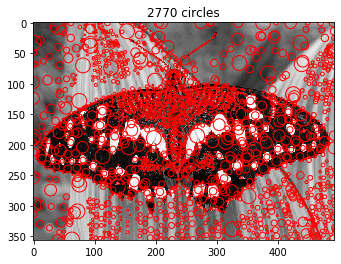

In [19]:
detect_blobs_scaling(butterfly, 1.0, 12, 1.255)

Time taken: 2.7497823238372803


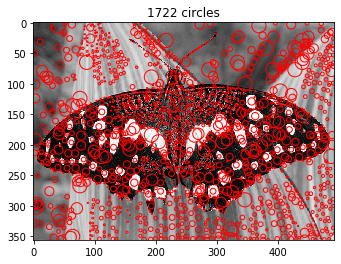

In [20]:
detect_blobs_downsample(butterfly, 1.0, 12, 1.25)

Time taken: 4.494998216629028


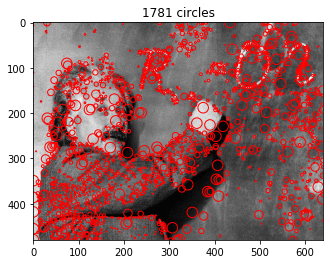

In [21]:
detect_blobs_scaling(einstein, 1.0, 12, 1.25)

Time taken: 4.38228178024292


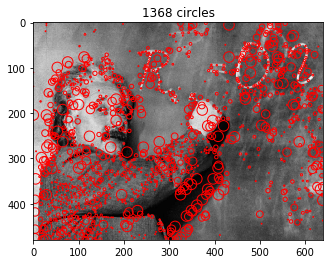

In [22]:
detect_blobs_downsample(einstein, 1.0, 12, 1.25)

Time taken: 3.2146952152252197


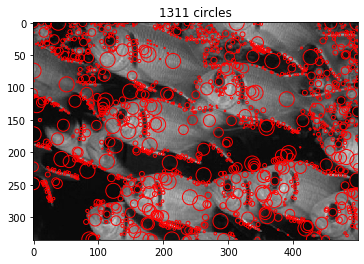

In [23]:
detect_blobs_scaling(fishes, 1.0, 12, 1.25)

Time taken: 2.594700574874878


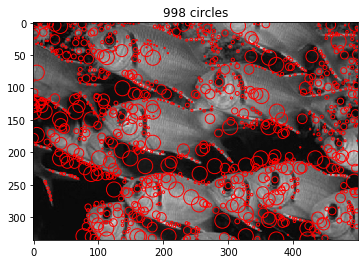

In [24]:
detect_blobs_downsample(fishes, 1.0, 12, 1.25)

Time taken: 1.9003472328186035


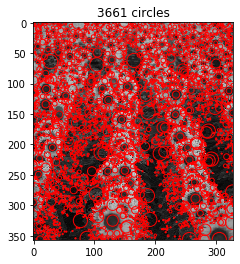

In [25]:
detect_blobs_scaling(sunflowers, 1.0, 12, 1.25)

Time taken: 1.7070059776306152


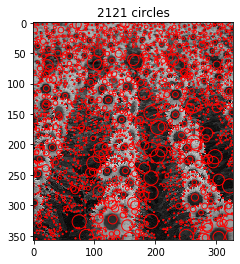

In [26]:
detect_blobs_downsample(sunflowers, 1.0, 12, 1.25)

Time taken: 2.2922418117523193


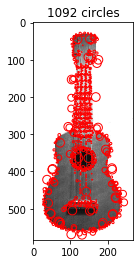

In [27]:
detect_blobs_scaling(ukulele, 1.0, 12, 1.25)

Time taken: 2.2794692516326904


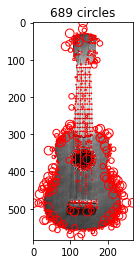

In [28]:
detect_blobs_downsample(ukulele, 1.0, 12, 1.25)

Time taken: 13.818647623062134


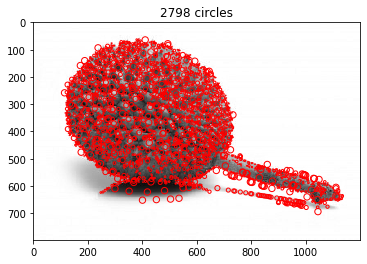

In [29]:
detect_blobs_scaling(durian, 1.0, 12, 1.25)

Time taken: 13.976556062698364


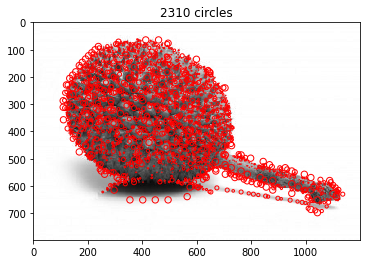

In [30]:
detect_blobs_downsample(durian, 1.0, 12, 1.25)

Time taken: 21.289671421051025


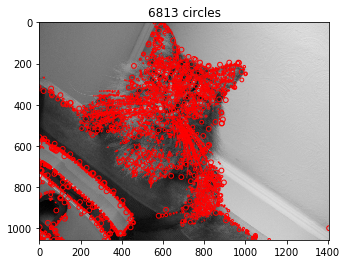

In [31]:
detect_blobs_scaling(cat, 1.0, 12, 1.25)

Time taken: 21.535979747772217


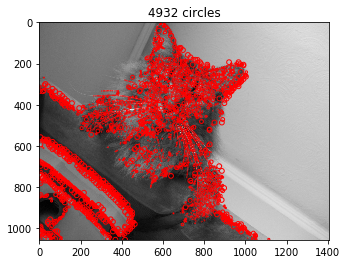

In [32]:
detect_blobs_downsample(cat, 1.0, 12, 1.25)

Time taken: 10.723356485366821


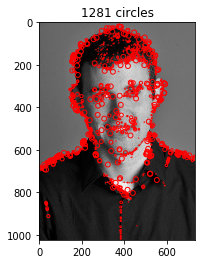

In [33]:
detect_blobs_scaling(derek, 1.0, 12, 1.25)

Time taken: 11.242058992385864


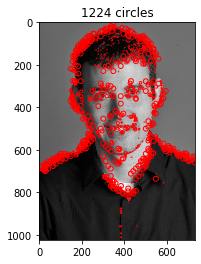

In [34]:
detect_blobs_downsample(derek, 1.0, 12, 1.25)